# Contacts vs distance

Welcome to the cooltools expected & contacts-vs-distance notebook!

The strongest signal in a typical Hi-C map is the decay of contact frequency with **genomic separation** (also referred to as **genomic distance**). In the Hi-C field, this decay is often interchangeably referred to as the: 

* **expected** because one "expects" a certain average contact frequency at a given genomic separation
* **scaling** which is borrowed from the polymer physics literature
* **P(s) curve** contact *probability*, *P*, as a function of genomic *separation*, *s*. 

The monotonic decay of contacts with genomic separation is reflective of the polymeric nature of chromosomes and can tell us about the global folding patterns of the genome. 

This decay has been observed to vary through the cell cycle, across cell types, and after degredation of structural maintenance of chromosomes complexes (SMCs) in both interphase and mitosis. 

The goals of this notebook are to:

* calculate the P(s) of a given cooler
* plot the P(s) curve
* smooth the P(s) curve with logarithmic binning
* plot the derivative of P(s)
* plot the P(s) between two different genomic regions
* plot the matrix of average contact frequencies between different chromosomes

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools

In [9]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [10]:
# Load a Hi-C map at a 1kb resolution from a cooler file.
resolution = 1000 # note this might be slightly slow on a laptop
                  # and could be lowered to 10kb for increased speed
clr = cooler.Cooler('./test.mcool::/resolutions/'+str(resolution))

In addition to data stored in a cooler, the analyses below make use
of where chromosomal arms start and stop to calculate contact frequency versus distance curves
within arms. For commonly-used genomes, bioframe can be used to fetch these 
annotations directly from UCSC. For less commonly-used genomes, a table of arms, or chromosomes 
can be loaded in directly with pandas, e.g.  

`chromsizes = pd.read_csv('chrom.sizes', sep='\t')`

Regions for calculating expected should be provided as a [viewFrame](https://bioframe.readthedocs.io/en/latest/guide-intervalops.html#genomic-views), i.e. a dataframe with four columns, chrom, start, stop, name,
where entries in the name column are unique and the intervals are non-overlapping. If the chromsizes table does not have a name column, it can be created with  `bioframe.core.construction.add_ucsc_name_column(bioframe.make_viewframe(chromsizes))`.

In [11]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


### Calculate the P(s) curve

To calculate the average contact frequency as a function of genomic separation, we use the fact that each diagonal of a Hi-C map records contacts between loci separated by the same genomic distance. For example, the 3rd diagonal of our matrix contains contacts between loci separated by 3-4kb (note that diagonals are 0-indexed). Thus, we calculate the average contact frequency, *P(s)*, at a given genomic distance, *s*, as the average value of all pixels of the corresponding diagonal. This operation is performed by `cooltools.expected_cis`.

Note that we calculate the *P(s)* separately for each chromosomal **arm**, by providing  `hg38_arms` as a `view_df`. This way we will ignore contacts accross the centromere, which is generally a good idea, since such contacts have a slightly different decay versus genomic separation.

In [14]:
# cvd == contacts-vs-distance
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=hg38_arms,
    smooth=False,
    aggregate_smoothed=False,
    nproc=4 #if you do not have multiple cores available, set to 1
)

This function calculates average contact frequency for raw and normalized interactions ( `count.avg` and `balanced.avg`) for each diagonal and each regions in the `hg38_arms` of a Hi-C map. It aslo keeps the sum of raw and normalized interaction counts (`count.sum` and `balanced.sum`) as well as the number of valid (i.e. non-masked) pixels at each diagonal, `n_valid`.

In [16]:
display(cvd.head(4))
display(cvd.tail(4))

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr2_p,chr2_p,0,86055,NaN,NaN,NaN,NaN
1,chr2_p,chr2_p,1,85282,NaN,NaN,NaN,NaN
2,chr2_p,chr2_p,2,84918,10842540.0,8344.916674,127.682470,0.098270
3,chr2_p,chr2_p,3,84649,4733321.0,3623.417357,55.917034,0.042805


,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
325450,chr17_q,chr17_q,58540,0,0.0,0.0,NaN,NaN
325451,chr17_q,chr17_q,58541,0,0.0,0.0,NaN,NaN
325452,chr17_q,chr17_q,58542,0,0.0,0.0,NaN,NaN
325453,chr17_q,chr17_q,58543,0,0.0,0.0,NaN,NaN


Note that the data from the first couple of diagonals are masked. This is done intentionally, since interactions at these diagonals (very short-ranged) are contaminated by non-informative Hi-C byproducts - dangling ends and self-circles. 

### Plot the P(s) curve

Time to plot *P(s)* !

The first challenge  is that Hi-C has a very wide dynamic range. Hi-C probes genomic separations ranging from 100s to 100,000,000s of basepairs and contact frequencies also tend to span many orders of magnitude.

Plotting such data in the linear scale would reveal only a part of the whole picture. Instead, we typically switch to double logarithmic (aka log-log) plots, where the x and y coordinates vary by orders of magnitude.

With the flags used above, `expected_cis()` does not smooth or aggregate across regions. This can lead to noisy P(s) curves for each region:

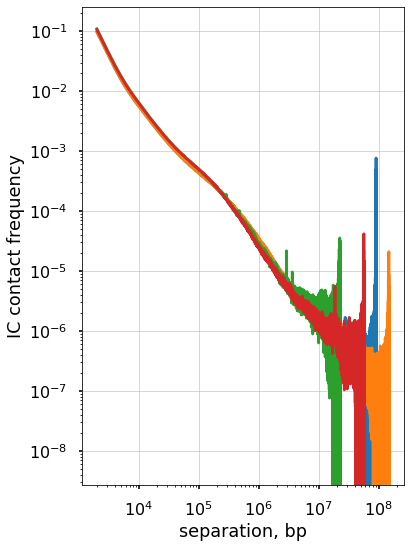

In [17]:
cvd['s_bp'] = cvd['dist']* resolution
f, ax = plt.subplots(1,1)

for region in hg38_arms['name']:
    ax.loglog(
        cvd['s_bp'].loc[cvd['region1']==region],
        cvd['balanced.avg'].loc[cvd['region1']==region],
    )
    ax.set(
        xlabel='separation, bp', 
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

The non-smoothed curves plotted above form characteristic "fans" at longer separations. This happens for two reasons: (a) we plot values of **each** diagonal separately and thus each decade of s contains 10x more points, and (b) due to the polymer nature of chromosomes, contact frequency at large genomic separations are lower and thus more affected by sequencing depth.

This issue is more that just cosmetic, as this noise would prevent us from doing finer analyses of *P(s)* and propagate into data derived from *P(s)*. However, there is a simple solution: we can calculate *P(s)* not for individual diagonals, but rather for whole groups of consecutive diagonals (a.k.a. genomic distance bins). This works because *P(s)* changes very gradually with *s*, so that consecutive diagonals have similar values. Furthermore, we can make each subsequent distance bin wider than the previous one, so that each order of magnitude of genomic separation contains the same number of bins. Such aggregation requires multiple steps, so `cooltools.api.expected` provides functions for this.


### Smoothing & aggregating P(s) curves

Instead of the flags above, we can pass flags to `expected_cis()` that return smoothed and aggregated columns for futher analysis (which are on by default).

In [18]:
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=hg38_arms,
    smooth=True,
    aggregate_smoothed=True,
    nproc=4
)

In [19]:
display(cvd_smooth_agg.head(4))

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr2_p,chr2_p,0,86055,NaN,NaN,NaN,NaN,NaN,NaN
1,chr2_p,chr2_p,1,85282,NaN,NaN,NaN,NaN,0.001043,0.001060
2,chr2_p,chr2_p,2,84918,10842540.0,8344.916674,127.682470,0.098270,0.087228,0.088615
3,chr2_p,chr2_p,3,84649,4733321.0,3623.417357,55.917034,0.042805,0.043116,0.043947


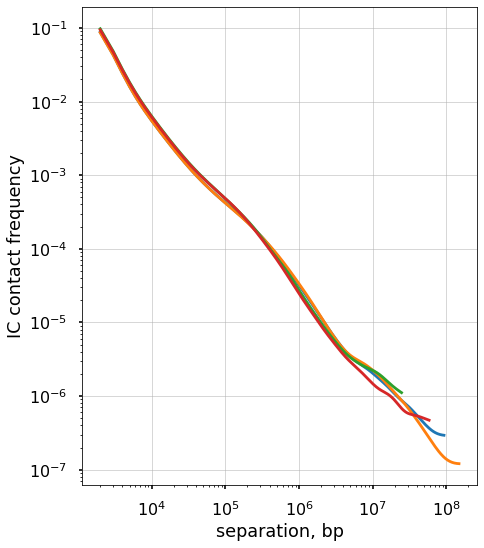

In [20]:
cvd_smooth_agg['s_bp'] = cvd_smooth_agg['dist']* resolution
cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['dist'] < 2] = np.nan
f, ax = plt.subplots(1,1)

for region in hg38_arms['name']:
    ax.loglog(
        cvd_smooth_agg['s_bp'].loc[cvd_smooth_agg['region1']==region],
        cvd_smooth_agg['balanced.avg.smoothed'].loc[cvd_smooth_agg['region1']==region],
    )
    ax.set(
        xlabel='separation, bp', 
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

The 'balanced.avg.smoothed.agg' is averaged across regions, and shows the same exact curve for each.

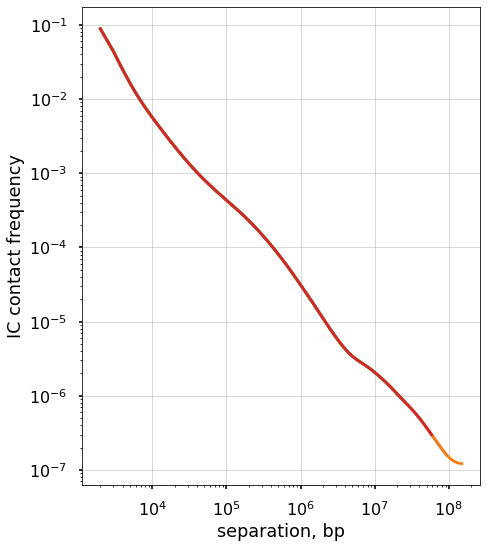

In [22]:
cvd_smooth_agg['s_bp'] = cvd_smooth_agg['dist']* resolution
cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['dist'] < 2] = np.nan
f, ax = plt.subplots(1,1)

for region in hg38_arms['name']:
    ax.loglog(
        cvd_smooth_agg['s_bp'].loc[cvd_smooth_agg['region1']==region],
        cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['region1']==region],
    )
    ax.set(
        xlabel='separation, bp', 
        ylabel='IC contact frequency')
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

#### Plot the smoothed P(s) curve and its derivative

Logbin-smoothing of P(s) reduces the "fanning" at longer s and enables us to plot the derivative of the P(s) curve in the log-log space. This derivative is extremely informative, as it can be compared to predictions from various polymer models.

This can currently be calculated with the `logbin_expected` function from the cvd table.

In [23]:
# Logbin-expected aggregates P(s) curves per region over exponentially increasing distance bins.
lb_cvd, lb_slopes, lb_distbins = cooltools.api.expected.logbin_expected(cvd)

# The resulting table contains P(s) curves for each individual region.
# Cooltools has another function to aggregate these curves into a single genome-wide curve.
lb_cvd_agg, lb_slopes_agg = cooltools.api.expected.combine_binned_expected(
    lb_cvd,
    binned_exp_slope=lb_slopes
)

lb_cvd_agg['s_bp'] = lb_cvd_agg['dist.avg'] * clr.binsize 
lb_slopes_agg['s_bp'] = lb_slopes_agg['dist.avg'] * clr.binsize 

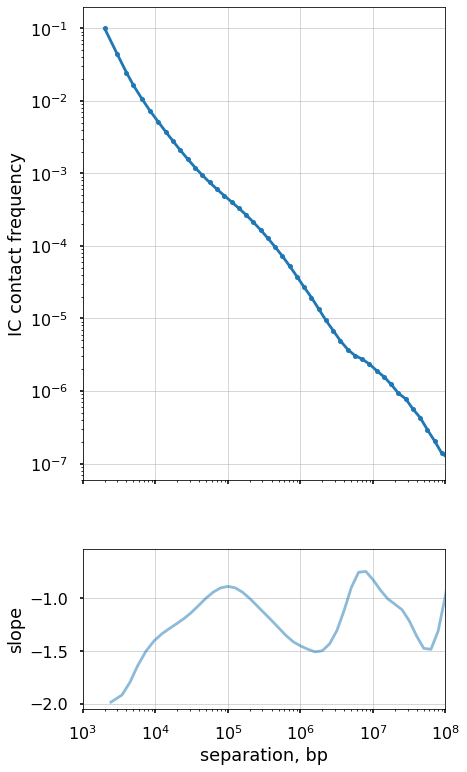

In [24]:
f, axs = plt.subplots(
    figsize=(6.5,13),
    nrows=2, 
    gridspec_kw={'height_ratios':[6,2]}, 
    sharex=True)
ax = axs[0]
ax.loglog(
    lb_cvd_agg['s_bp'],
    lb_cvd_agg['balanced.avg'],
    'o-',
    markersize=5,
)

ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]
ax.semilogx(
    lb_slopes_agg['s_bp'],
    lb_slopes_agg['slope'],
    alpha=0.5
)

ax.set(
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)

### Plot the P(s) curve for interactions between different regions.

Finally, we can plot P(s) curves for contacts between loci that belong to different regions. 

A commonly considered situation is for trans-arm interactions, i.e. contacts between loci on the opposite side of a centromere. Such P(s) can be calculated via `cooltools.expected_cis` by passing `intra_only=False`.

In [25]:
# cvd_inter == contacts-vs-distance between chromosomal arms
cvd_inter = cooltools.expected_cis(
    clr=clr,
    view_df=hg38_arms,
    intra_only=False,
)
# select only inter-arm interactions:
cvd_inter = cvd_inter[ cvd_inter["region1"] != cvd_inter["region2"] ]

ValueError: view_df is not a valid viewframe or incompatible

In [ ]:
# Logbin-expected aggregates P(s) curves per region over exponentially increasing distance bins.
cvd_inter['region'] = cvd_inter['region1'] + '&' + cvd_inter['region2']
lb_inter_cvd, lb_inter_slopes, lb_inter_distbins = cooltools.api.expected.logbin_expected(cvd_inter)

# The resulting table contains P(s) curves for each individual region.
lb_cvd_inter_agg, lb_inter_slopes_agg = cooltools.api.expected.combine_binned_expected(
    lb_inter_cvd,
    lb_inter_slopes
)

lb_cvd_inter_agg['s_bp'] = lb_cvd_inter_agg['dist.avg'] * clr.binsize 
lb_inter_slopes_agg['s_bp'] = lb_inter_slopes_agg['dist.avg'] * clr.binsize 


In [ ]:
f, ax = plt.subplots(1,1,
    figsize=(5,5),)

ax.loglog(
    lb_cvd_inter_agg['s_bp'],
    lb_cvd_inter_agg['balanced.avg'],
    marker='o',
    markersize=5,
)


ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency',
    title="average interactions between chromosomal arms")
ax.grid(lw=0.5)
ax.set_aspect(1.0)


### Averaging interaction frequencies in blocks

For *trans* (i.e. inter-chromosomal) interactions, the notion of "genomic separation" becomes irrelevant, as loci on different chromosomes are not connected by any polymer chain. Thus, the "expected" level of trans interactions is a scalar, the average interaction frequency for a given pair of chromosomes.

In [ ]:
# average contacts, in this case between pairs of chromosomal arms:
ac = cooltools.expected_trans(
    clr,
    view_df = None  # full chromosomes as the view
)

# average raw interaction counts and normalized contact frequencies are already in the result
ac

In [ ]:
# pivot a table to generate a pair-wise average interaction heatmap:
acp = (ac 
    .pivot_table(values="balanced.avg",
                 index="region1",
                 columns="region2",
                 observed=True) 
    .reindex(index=clr.chromnames,
             columns=clr.chromnames)
)

In [ ]:
fs = 14

f, axs = plt.subplots(
    figsize=(6.0,5.5),
    ncols=2,
    gridspec_kw={'width_ratios':[20,1],"wspace":0.1},
)
# assign heatmap and colobar axis:
ax, cax = axs
# draw a heatmap, using log-scale for interaction freq-s:
acpm = ax.imshow(
    acp,
    cmap="YlOrRd",
    norm=colors.LogNorm(),
    aspect=1.0
)
# assign ticks and labels (ordered names of chromosome arms):
ax.set(
    xticks=range(len(clr.chromnames)),
    yticks=range(len(clr.chromnames)),
    title="average interactions\nbetween chromosomes",
)
ax.set_xticklabels(
    clr.chromnames,
    rotation=30,
    horizontalalignment='right',
    fontsize=fs
)
ax.set_yticklabels(
    clr.chromnames,
    fontsize=fs
)
# draw a colorbar of interaction frequencies for the heatmap:
f.colorbar(
    acpm,
    cax=cax,
    label='IC contact frequency'
)

# draw a grid around values:
ax.set_xticks(
    [x-0.5 for x in range(1,len(clr.chromnames))],
    minor=True
)
ax.set_yticks(
    [y-0.5 for y in range(1,len(clr.chromnames))],
    minor=True
)
ax.grid(which="minor")
